# Sentiment analysis : Movies review text in Finnish


## Data

The data is obtained from leffatykki.com. 

In [191]:
import pandas as pd
import numpy as np

# Read in the data
df1 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_1.csv')
df2 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_2.csv')
df3 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_3.csv')
df4 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_4.csv')
df5 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_5.csv')
df6 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_6.csv')


df = pd.concat([df1, df2, df3, df4, df5, df6])

print(df.head())

print('\nOriginal data dimension : {}'.format(df.shape))

   Unnamed: 0  score                                               text  \
0           0   60.0  Scaramanga on kuuluisa palkkamurhaaja, jonka t...   
1           1   60.0  Avauskohtaus heti ikonisen gunbarrelin jälkeen...   
2           2   60.0  1973 valmistui kansan suosikki Bond Live And L...   
3           3   90.0  Vuonna 1995 saatiin valmiiksi uusi Bond-elokuv...   
4           4   90.0  Kuusi vuotta ehti kulua ja sinä aikana tapahtu...   

                                               title  
0   Parhaimmillaan kuitenkin oikein hyvää viihdettä.  
1                        Kokonaisuus on epätasainen.  
2  Toiminta on jonkun verran hakusessa, joka lask...  
3  Kultainen silmä kuuluu parhaimpiin Bond-elokuv...  
4                                         Hyvä Bond.  

Original data dimension : (16605, 4)


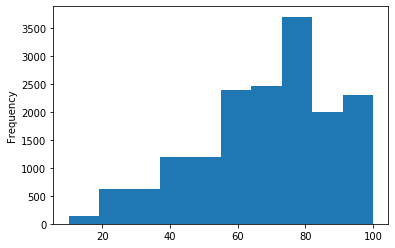

In [181]:
df['score'].plot.hist()


### Data preparation

1. Shuffle the rows of read in data.
2. Set score scale to (1 - 10). Original data has scale (10 - 100).
3. Drop rows that has empty review text.
4. Define binary sentiment classes (1 for positive; 0 for negative) based on score (1 - 3 as negative, 8 - 10 as positive, drop rows with score 4 - 7). From the histogram above, we can see we will have unbalanced data for the classes.


In [197]:
# shuffle df rows
df = df.sample(frac=1).reset_index(drop=True)

# set score to scale 1--10
df['score']=df['score']/10

# drop rows with NaN review text
df = df[df['text'].notna()]

# Remove 'neutral' ratings (score 4 -7)
df = df[(df['score'] < 4)|(df['score'] > 7) ]

# Encode 8, 9, 10 as 1 (Positive)
# Encode 1, 2, 3 as 0 (Negative)
df['Positively Rated'] = np.where(df['score'] > 7, 1, 0)

print(df.head())

print('\nDimension of the data after pre-processing : {}'.format(df.shape))

   Unnamed: 0  score                                               text  \
1        1197   10.0  Katumus alkaa kohtauksella pienessä georgialai...   
2          80    8.0  Mike Enslin (John Cusack) on kirjailija. Hän k...   
5        2174    3.0  Mietiskelin jo ennen elokuvan alkua, että olis...   
6         101    9.0  "Let's just say that I want to believe"Pitkään...   
7        3799    9.0  Planet Terror on toinen puolikas Tarantinon ja...   

                                               title  Positively Rated  
1  Hämmästyttävän suora ja häpeilemätön satiiri e...                 1  
2           Tässä kauhuleffassa on mukana mysteeriä.                 1  
5                                      Turha tekele.                 0  
6  Lähes täydellinen X-Files tulkinta ja yksi vuo...                 1  
7           Filmi on alusta asti visuaalista riemua.                 1  

Dimension of the data after pre-processing : (9365, 5)


In [202]:
# Check portion of class 1
print('Proportion of data with positive rating (class 1) : {}%'.format(round(df['Positively Rated'].mean()*100,2)))


Proportion of data with positive rating (class 1) : 85.32%


## Split data into training and test sets

In [7]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['Positively Rated'], 
                                                    random_state=7,
                                                    test_size=0.25)

## Logistic regression

Here we tranform the review text to word count vector representation and then generate tfidf matrix and fit to a logistic regression model.  

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

model_logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C=0.6, class_weight='balanced')),
                    ]) 
model_logreg.fit(X_train, y_train)


C:\Users\meiye\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=

AUC:  0.9505154948150812


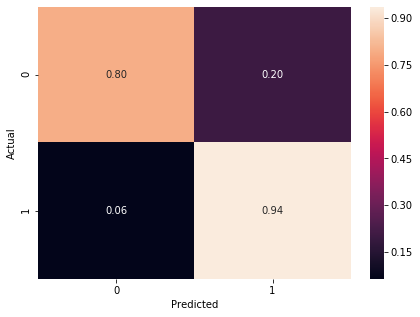

In [330]:
## Prediction
predictions = model_logreg.predict(X_test)
prediction_prob = model_logreg.predict_proba(X_test)

## Evaluate ROC-AUC score
print('AUC: ', roc_auc_score(y_test, prediction_prob[:,1]))


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## generate and print confusion matrix
#
cm = confusion_matrix(y_test, predictions)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [331]:
logreg_vect = model_logreg.get_params()['vect']
logreg_clf = model_logreg.get_params()['clf']

# get the feature names as numpy array
feature_names = np.array(logreg_vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = logreg_clf.coef_[0].argsort()

# Find the 20 smallest and 10 largest coefficients
# The 20 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))

Smallest Coefs:
['edes' 'sitten' 'huono' 'mitään' 'ei' 'surkea' 'olisi' 'että'
 'ilmeisesti' 'juoni' 'ihan' 'oikein' 'vain' 'jos' 'valitettavasti'
 'tylsä' 'miksi' 'yritetään' 'lähinnä' 'sentään']

Largest Coefs: 
['ja' 'myös' 'hyvin' 'hän' 'hieman' 'loistava' 'tekee' 'sekä' 'paras'
 'toimii' 'elokuva' 'on' 'kaikille' 'joka' 'silti' 'loistavasti'
 'hienosti' 'hänen' 'mies' 'nimimerkki']


# Stoplist generation using mutual information based feature selection

Instead of using standard stopwords list, mutual information based feature selection method is used here to select poor class discriminating variables as stoplist.

In [255]:
# Fit the CountVectorizer to the training data
vectX_train = CountVectorizer().fit(X_train)

len(vectX_train.get_feature_names())

249040

In [258]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vectX_train.transform(X_train)

X_train_vectorized

<7023x249040 sparse matrix of type '<class 'numpy.int64'>'
	with 1701312 stored elements in Compressed Sparse Row format>

In [259]:
from sklearn.feature_selection import mutual_info_classif as mi_classif

mi = mi_classif(X_train_vectorized, y_train)


In [261]:
mi_df = pd.Series(mi)

fea_df=pd.Series(vect.get_feature_names())

fea_mi_df = pd.concat([fea_df, mi_df], axis=1, ignore_index=True)
fea_mi_df.columns=['feature', 'mi']
fea_mi_sorted= fea_mi_df.sort_values(by=['mi'], ascending=False)

print( 'Head : ', fea_mi_sorted.head(), '\nTail :', fea_mi_sorted.tail())

Head :         feature        mi
24788     edes  0.033561
50423    huono  0.019469
129100    myös  0.019329
187969  sitten  0.016349
123242  mitään  0.015579 
Tail :             feature            mi
142728    oscareita  2.021906e-09
125375       muisto  2.021906e-09
66650   jännittäviä  2.021906e-09
214988     tulemaan  2.021906e-09
162939     pysähtyy  2.021906e-09


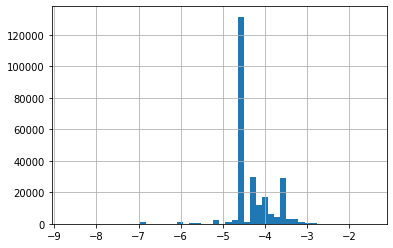

In [338]:
len(fea_mi_sorted[fea_mi_sorted.mi<1e-5])

np.log10(fea_mi_sorted['mi']).hist(bins=50)

In [280]:
stoplist_len = len(fea_mi_sorted[fea_mi_sorted.mi<1e-5])

stoplist=list(fea_mi_sorted.feature[-stoplist_len:-1])

### Re-train logistic regression classifier with words in stoplist as stopwords

In [281]:
model_logreg_stw = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C=0.6, class_weight='balanced')),
                    ]) 
model_logreg_stw.fit(X_train, y_train)


C:\Users\meiye\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['rauhaan', 'leffana', 'perustuvat',
                                             'aamulla', 'kohtauksella',
                                             'leikki', 'summa', 'tarinoita...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                                    fit_interce

AUC:  0.950466043277588


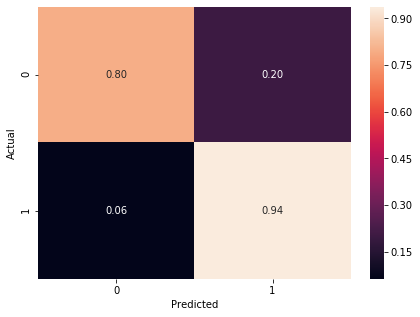

In [282]:
## Prediction
predictions_stw = model_logreg_stw.predict(X_test)
prediction_prob_stw = model_logreg_stw.predict_proba(X_test)

## Evaluate ROC-AUC score
print('AUC: ', roc_auc_score(y_test, prediction_prob_stw[:,1]))


## generate and print confusion matrix
#
cm = confusion_matrix(y_test, predictions_stw)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Naive Bayes

## Multinomial Naive Bayes

In [292]:
from sklearn import naive_bayes
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

model_MNB = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist)),
                     #('tfidf', TfidfTransformer()),
                     ('clf', naive_bayes.MultinomialNB()),
                    ]) 
model_MNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['rauhaan', 'leffana', 'perustuvat',
                                             'aamulla', 'kohtauksella',
                                             'leikki', 'summa', 'tarinoita...
                                             'annettiin', 'senkun',
                                             'kakkoseksi', 'tarkoitti',
                                             'kuuloinen', 'läheiset',
                                             'osanneet', 'lyhyet',
                                

Multinomial NB classifier, AUC:  0.9638659114068212


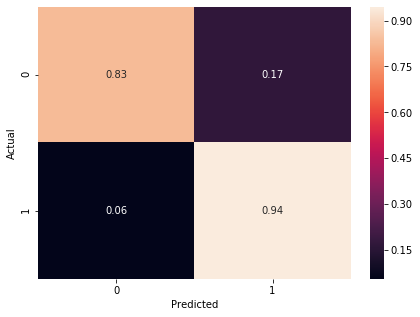

In [303]:
# from sklearn.metrics import roc_auc_score

predictions_MNB = model_MNB.predict(X_test)
prediction_proba_MNB = model_MNB.predict_proba(X_test)

print('Multinomial NB classifier, AUC: ', roc_auc_score(y_test, prediction_proba_MNB[:,1]))

## generate and print confusion matrix
#
cm = confusion_matrix(y_test, predictions_MNB)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [291]:
predict = model_MNB.predict(['tosi surkea'])
predict



array([0])

## Complement Naive bayes

In [344]:
model_CNB = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist[-1300:-1])),
#                      ('tfidf', TfidfTransformer()),
                     ('clf', naive_bayes.ComplementNB(alpha=1)),
                    ]) 
model_CNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['paikallisessa', 'nenän',
                                             'valitut', 'olematta', 'pyritään',
                                             'juonenkäänteiden', 'onkohan',...
                                             'spoilerivaroitus', 'mitkään',
                                             'kontrastia', 'syvällisesti',
                                             'pulassa', 'jälkimmäistä',
                                             'edellisiin', 'luominen', 'puuhaa',
      

In [345]:

prediction_proba_CNB = model_CNB.predict_proba(X_test)

print('AUC: ', roc_auc_score(y_test, prediction_proba_CNB[:,1]))

# predictions


AUC:  0.9649988011748488


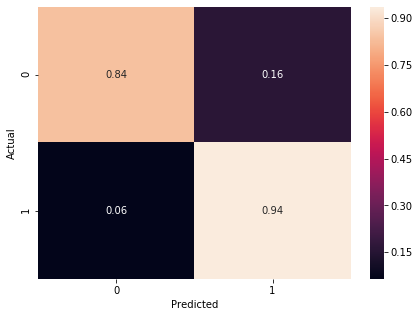

In [346]:
predictions_CNB = model_CNB.predict(X_test)

cm = confusion_matrix(y_test, predictions_CNB)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Analyze features

In [160]:
mdl=model_NB.get_params()['clf']
vectorizer=model_NB.get_params()['vect']

In [161]:
def show_most_informative_features(vectorizer, clf, n=30):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer, mdl)

	-13.5279	surkein        		-3.0488	ja             
	-13.1224	hohhoijaa      		-3.2255	on             
	-13.1224	huonous        		-4.3098	ei             
	-13.1224	mukiinmenevää  		-4.5947	mutta          
	-13.1224	olevinaan      		-4.9255	joka           
	-13.1224	pohjanoteeraus 		-4.9610	se             
	-13.1224	random         		-5.0317	että           
	-13.1224	surkeampi      		-5.0816	myös           
	-13.1224	viitsitty      		-5.1892	elokuva        
	-12.8347	geneeristä     		-5.1995	kuin           
	-12.8347	hanurista      		-5.2240	ole            
	-12.8347	huonoudellaan  		-5.2430	ovat           
	-12.8347	huonoudessaan  		-5.2623	elokuvan       
	-12.8347	hävettää       		-5.4442	hän            
	-12.8347	kakkaa         		-5.4657	niin           
	-12.8347	katsoisin      		-5.5035	kun            
	-12.8347	kohellus       		-5.5242	sen            
	-12.8347	maineella      		-5.7042	tämä           
	-12.8347	mielikuvitukseton		-5.7320	oli            
	-12.8347	pitkästyttävä  		-5

In [162]:
mdl1=model_CNB.get_params()['clf']
vectorizer1=model_CNB.get_params()['vect']
show_most_informative_features(vectorizer1, mdl1)

	3.5285	ja             		12.7280	äärimmäisyyksiin
	3.5997	on             		12.7280	äärimmäisen viihdyttävä
	4.3478	ei             		12.7280	äärimmäisellä  
	4.8802	mutta          		12.7280	ääniä ja       
	4.9852	että           		12.7280	ääniraita on   
	5.1437	se             		12.7280	äänimaailman   
	5.3341	ole            		12.7280	äänielokuvan   
	5.4108	kuin           		12.7280	ääni ei        
	5.4141	niin           		12.7280	äänenlaatu     
	5.4549	elokuvan       		12.7280	äänekäs        
	5.4619	joka           		12.7280	älykkäin       
	5.5231	ovat           		12.7280	äkkipikainen   
	5.5876	kun            		12.7280	äitiinsä       
	5.6624	elokuva        		12.7280	äidilleen      
	5.7277	tämä           		12.7280	zimmer         
	5.7470	oli            		12.7280	zemeckis       
	5.7573	vain           		12.7280	zach           
	5.7801	sen            		12.7280	yönsä          
	5.9058	sitten         		12.7280	yön ritarin    
	5.9402	tai            		12.7280	yön ritari     
	5.9676	mit